In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Define a simple U-Net-like model for denoising
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
        )
        self.middle = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [3]:
# Forward diffusion: Add noise to an image
def forward_diffusion(image, timesteps, beta_schedule):
    device = image.device
    betas = torch.linspace(beta_schedule[0], beta_schedule[1], timesteps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    noise = torch.randn_like(image)
    random_timestep = torch.randint(0, timesteps, (1,), device=device)
    alpha_t = alphas_cumprod[random_timestep].view(-1, 1, 1, 1)
    noisy_image = image * alpha_t.sqrt() + noise * (1 - alpha_t).sqrt()
    return noisy_image, noise, random_timestep

In [4]:
# Define training loop
def train_diffusion_model():
    # Hyperparameters
    epochs = 5
    batch_size = 64
    learning_rate = 1e-3
    timesteps = 100
    beta_schedule = (0.1, 0.02)  # Linearly decreasing betas

    # Data preparation
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model, loss, optimizer
    model = UNet().cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training
    model.train()
    for epoch in range(epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.cuda()
            noisy_images, noise, t = forward_diffusion(images, timesteps, beta_schedule)
            predicted_noise = model(noisy_images)

            loss = criterion(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    return model

In [5]:
# Train the model
trained_model = train_diffusion_model()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16972407.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 448468.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4264732.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1175160.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Step [1/938], Loss: 1.0024
Epoch [1/5], Step [101/938], Loss: 0.0718
Epoch [1/5], Step [201/938], Loss: 0.0435
Epoch [1/5], Step [301/938], Loss: 0.0139
Epoch [1/5], Step [401/938], Loss: 0.0170
Epoch [1/5], Step [501/938], Loss: 0.0134
Epoch [1/5], Step [601/938], Loss: 0.0104
Epoch [1/5], Step [701/938], Loss: 0.0200
Epoch [1/5], Step [801/938], Loss: 0.0090
Epoch [1/5], Step [901/938], Loss: 0.0148
Epoch [2/5], Step [1/938], Loss: 0.0095
Epoch [2/5], Step [101/938], Loss: 0.0113
Epoch [2/5], Step [201/938], Loss: 0.0090
Epoch [2/5], Step [301/938], Loss: 0.0061
Epoch [2/5], Step [401/938], Loss: 0.0128
Epoch [2/5], Step [501/938], Loss: 0.0106
Epoch [2/5], Step [601/938], Loss: 0.0082
Epoch [2/5], Step [701/938], Loss: 0.0057
Epoch [2/5], Step [801/938], Loss: 0.0203
Epoch [2/5], Step [901/938], Loss: 0.0085
Epoch [3/5], Step [1/938], Loss: 0.0060
Epoch [3/5], Step [101/938], Loss: 0.0169
Epoch [

In [6]:
import matplotlib.pyplot as plt

# Visualization function
def visualize_results(model, dataset, timesteps, beta_schedule):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    original_image = dataset[0][0].unsqueeze(0).cuda()  # Get a single image, move to GPU
    with torch.no_grad():
        # Add noise
        noisy_image, noise, t = forward_diffusion(original_image, timesteps, beta_schedule)

        # Predict denoised image
        predicted_noise = model(noisy_image)
        alphas_cumprod = torch.cumprod(
            1 - torch.linspace(beta_schedule[0], beta_schedule[1], timesteps).cuda(), dim=0
        )
        alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)
        denoised_image = (noisy_image - predicted_noise * (1 - alpha_t).sqrt()) / alpha_t.sqrt()

    # Convert tensors to numpy arrays for plotting
    original_image = original_image.squeeze(0).cpu().numpy()
    noisy_image = noisy_image.squeeze(0).cpu().numpy()
    denoised_image = denoised_image.squeeze(0).cpu().numpy()

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image[0], cmap="gray")
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(noisy_image[0], cmap="gray")
    axs[1].set_title("Noisy Image")
    axs[1].axis("off")

    axs[2].imshow(denoised_image[0], cmap="gray")
    axs[2].set_title("Denoised Image")
    axs[2].axis("off")

    plt.show()


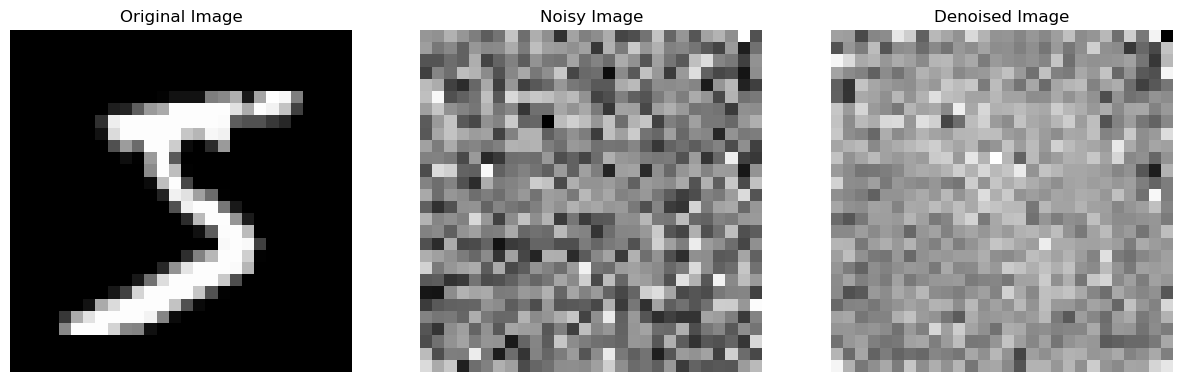

In [7]:
#trained_model = train_diffusion_model()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
visualize_results(trained_model, train_dataset, timesteps=100, beta_schedule=(0.1, 0.02))
